## Overview

In this notebook, I've trained a linear model, MLP, and LSTM on the Weinstock2016 dataset. 

The data is from the Weinstock2016 dataset with ~200 subjects. The only covariate for now is time which is split into year, month, hour, and minute. All models are designed to take in 196 measurements and predict the next 24. 

In [1]:
# load libraries 
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.weinstock2016 import *
from dataset import TSDataset
from conf import Conf
from models.mlp import *
from models.lstm import *

In [2]:
# loading the config file, setting the experiment name, and the seed for random pre-processing parts (like splitting)
cnf = Conf(conf_file_path='./conf/weinstock.yaml', seed=15, exp_name="Weinstock", log=False)

In [3]:
# call the data fromatter directly
data_formatter = WeinstockFormatter(cnf)

Dropped segments: 1012
Extracted segments: 1085


In [4]:
# extract train, val, and test datasets
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

Getting valid sampling locations.
# available segments=252901
Extracting 5000 samples out of 252901
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=474
Extracting all available segments.
Getting valid sampling locations.
# available segments=44660
Extracting 5000 samples out of 44660
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...


[ 0.05219857 -0.0880001   1.103775   -1.6791736   1.0141653   0.39664298]


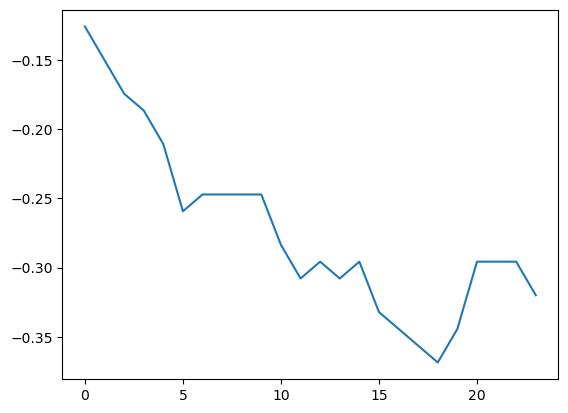

[ 0.05219857 -0.0880001  -1.2119602  -0.24402826 -0.72403276  0.20230493]


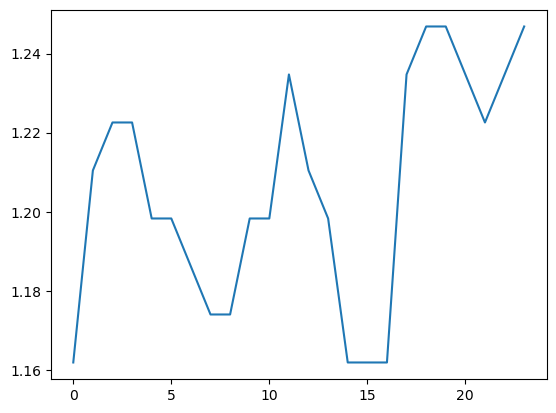

[ 0.05219857 -0.0880001  -1.0338267  -1.3921446  -0.14463343 -1.1459153 ]


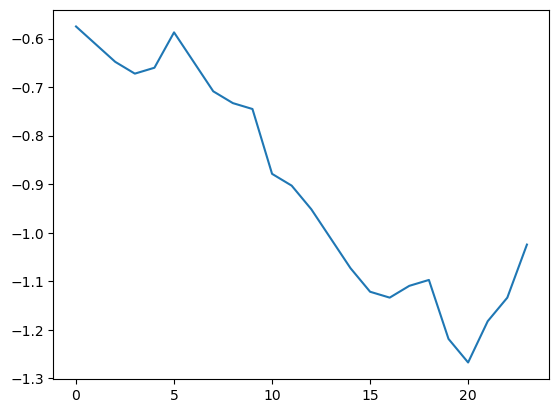

[ 0.05219857 -0.0880001  -1.0338267  -1.5356591  -1.5931318  -0.30783245]


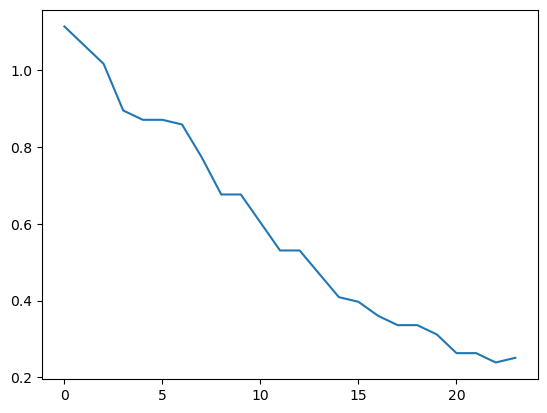

[ 0.05219857 -0.0880001   0.21310763  0.61705893 -0.43433312 -0.49002436]


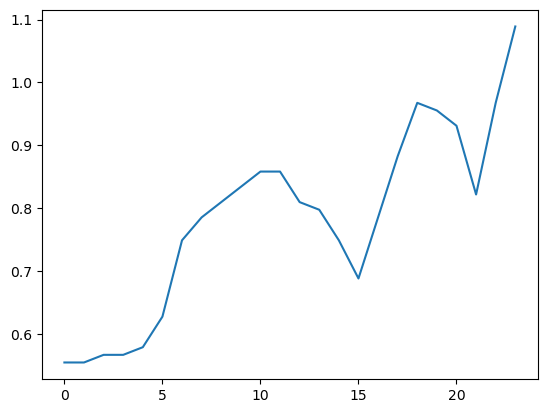

In [6]:
# plot inputs and outputs to check for issues
for i in range(5):
    x = test_dataset[i]['inputs']
    print(x[0, :])
    y = test_dataset[i]['outputs']

    # plt.plot(x[:, 5])
    plt.plot(y)
    plt.show()

In [5]:
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

This is just a linear regression model. The first linear layer (linear_collapse) takes the X matrix from 192x6 to 192x1. After squeezing to a $vector \in R^{192}$, it is passed to the actual linear layer (linear) going from $R^{192}$ to $R^{24}$.

In [22]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [23]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(100):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: 1.9095
Epoch [1/100], Val Loss: 1.5358
Epoch [2/100], Loss: 0.7096
Epoch [2/100], Val Loss: 1.4951
Epoch [3/100], Loss: 0.6604
Epoch [3/100], Val Loss: 1.4719
Epoch [4/100], Loss: 0.7660
Epoch [4/100], Val Loss: 1.4546
Epoch [5/100], Loss: 0.3654
Epoch [5/100], Val Loss: 1.4376
Epoch [6/100], Loss: 1.2339
Epoch [6/100], Val Loss: 1.4188
Epoch [7/100], Loss: 0.5678
Epoch [7/100], Val Loss: 1.3930
Epoch [8/100], Loss: 1.2494
Epoch [8/100], Val Loss: 1.3582
Epoch [9/100], Loss: 0.3312
Epoch [9/100], Val Loss: 1.3118
Epoch [10/100], Loss: 0.8238
Epoch [10/100], Val Loss: 1.2483
Epoch [11/100], Loss: 1.0270
Epoch [11/100], Val Loss: 1.1668
Epoch [12/100], Loss: 0.7596
Epoch [12/100], Val Loss: 1.0732
Epoch [13/100], Loss: 0.7289
Epoch [13/100], Val Loss: 0.9730
Epoch [14/100], Loss: 0.3738
Epoch [14/100], Val Loss: 0.8784
Epoch [15/100], Loss: 0.5701
Epoch [15/100], Val Loss: 0.7969
Epoch [16/100], Loss: 0.7235
Epoch [16/100], Val Loss: 0.7324
Epoch [17/100], Loss: 0.31

<All keys matched successfully>

In [24]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.1578


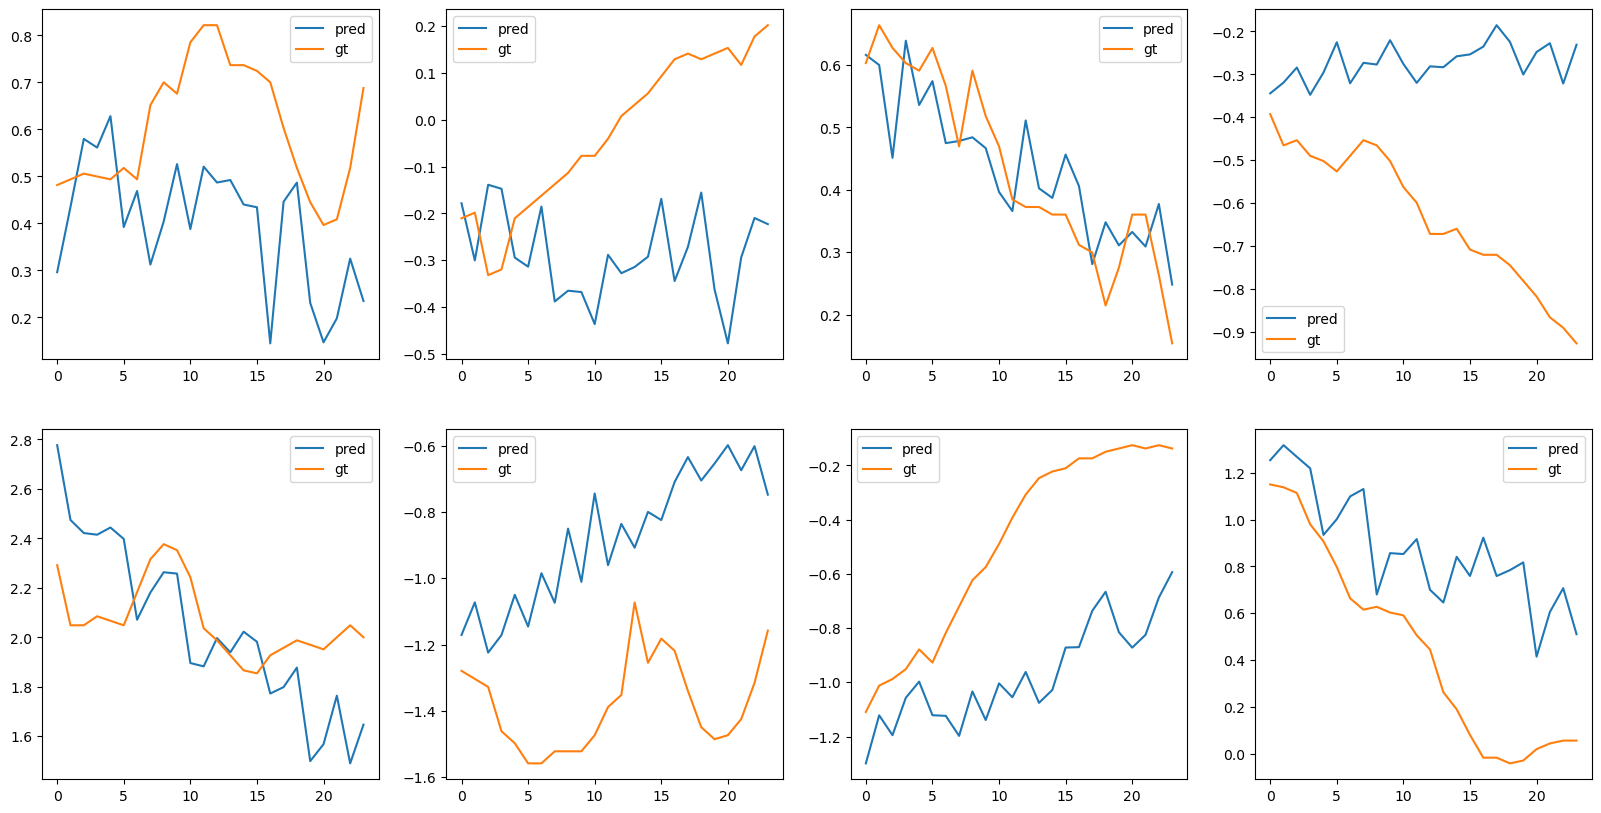

In [25]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## MLP

Training an MLP using the MLP class defined in models/mlp. To use the first original MLP, simply uncomment the block below.

In [12]:
# # define model
# class MLP(torch.nn.Module):
#     def __init__(self, n1):
#         super(MLP, self).__init__()
#         self.linear_collapse = torch.nn.Linear(6, 1)
#         self.linear = torch.nn.Linear(192, n1)
#         self.relu = torch.nn.ReLU()
#         self.linear2 = torch.nn.Linear(n1, 24)
        
#     def forward(self, x):
#         y_pred = self.linear2(self.relu(self.linear(torch.squeeze(self.linear_collapse(x)))))
#         return y_pred


In [19]:
# train model
best_loss = 1e10000
model = MLP(192, 6, 24, 36, 3, 0.3)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(100):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_mlp.pth')
# load best model
model.load_state_dict(torch.load('best_model_mlp.pth'))

Epoch [1/100], Loss: 0.8172
Epoch [1/100], Val Loss: 1.1667
Epoch [2/100], Loss: 0.5148
Epoch [2/100], Val Loss: 1.1707
Epoch [3/100], Loss: 0.5382
Epoch [3/100], Val Loss: 1.1683
Epoch [4/100], Loss: 1.1484
Epoch [4/100], Val Loss: 1.1668
Epoch [5/100], Loss: 1.9708
Epoch [5/100], Val Loss: 1.1701
Epoch [6/100], Loss: 1.2441
Epoch [6/100], Val Loss: 1.1631
Epoch [7/100], Loss: 0.7344
Epoch [7/100], Val Loss: 1.1662
Epoch [8/100], Loss: 1.0244
Epoch [8/100], Val Loss: 1.1644
Epoch [9/100], Loss: 0.7775
Epoch [9/100], Val Loss: 1.1685
Epoch [10/100], Loss: 0.7770
Epoch [10/100], Val Loss: 1.1644
Epoch [11/100], Loss: 0.9536
Epoch [11/100], Val Loss: 1.1680
Epoch [12/100], Loss: 0.7458
Epoch [12/100], Val Loss: 1.1644
Epoch [13/100], Loss: 0.8332
Epoch [13/100], Val Loss: 1.1662
Epoch [14/100], Loss: 0.9163
Epoch [14/100], Val Loss: 1.1655
Epoch [15/100], Loss: 1.5356
Epoch [15/100], Val Loss: 1.1666
Epoch [16/100], Loss: 0.9879
Epoch [16/100], Val Loss: 1.1647
Epoch [17/100], Loss: 0.90

<All keys matched successfully>

In [29]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.9987


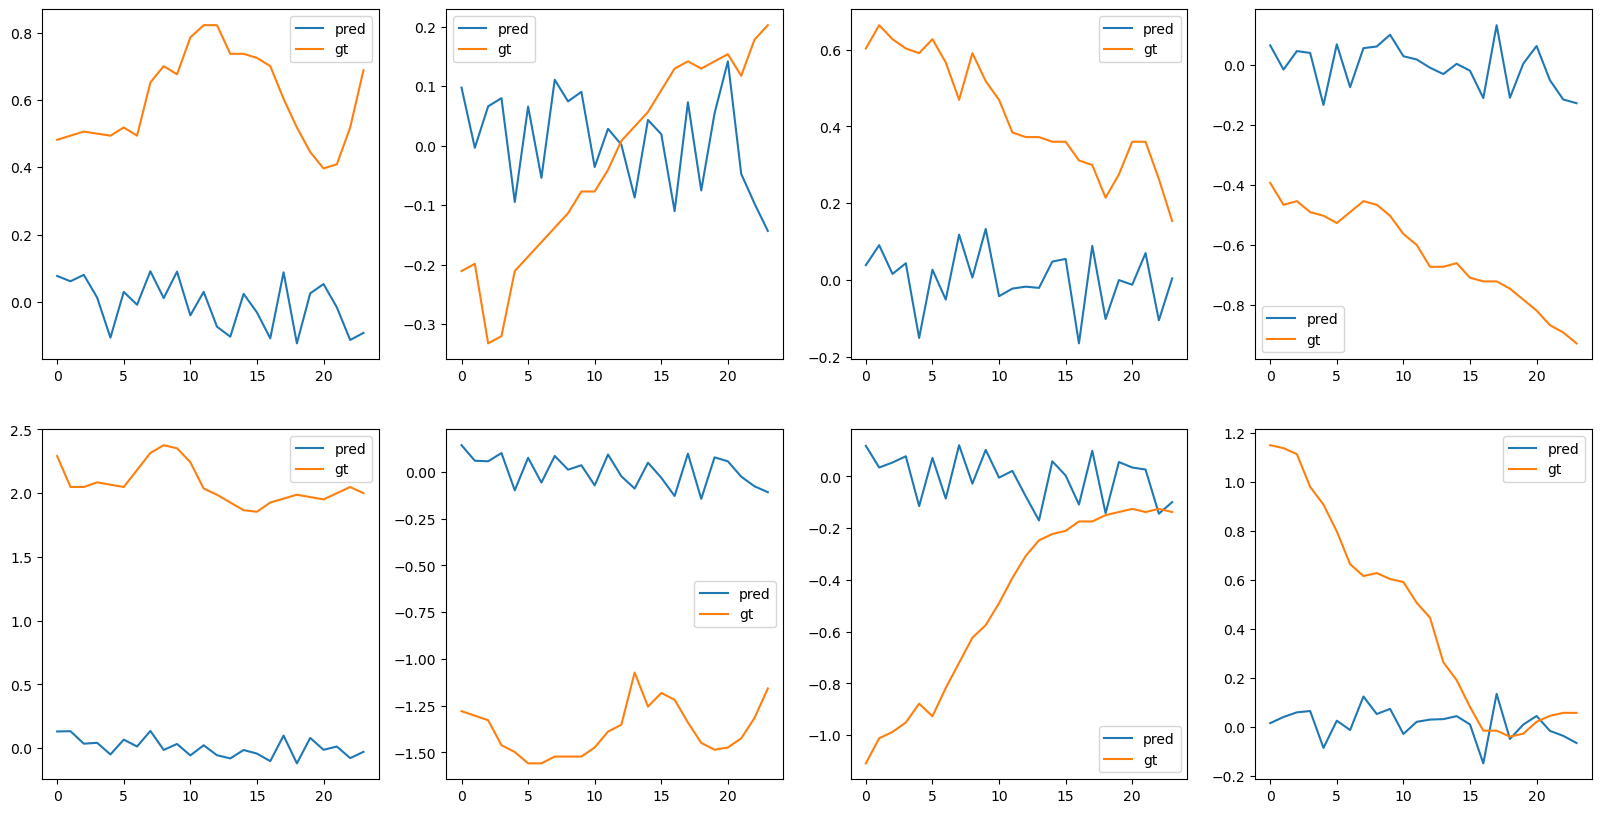

In [30]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## LSTM
Training an LSTM model  

Epoch [1/100], Loss: 1.0480
Epoch [1/100], Val Loss: 1.1638
1
Epoch [2/100], Loss: 1.4961
Epoch [2/100], Val Loss: 1.1805
Epoch [3/100], Loss: 1.4951
Epoch [3/100], Val Loss: 1.1800


<All keys matched successfully>

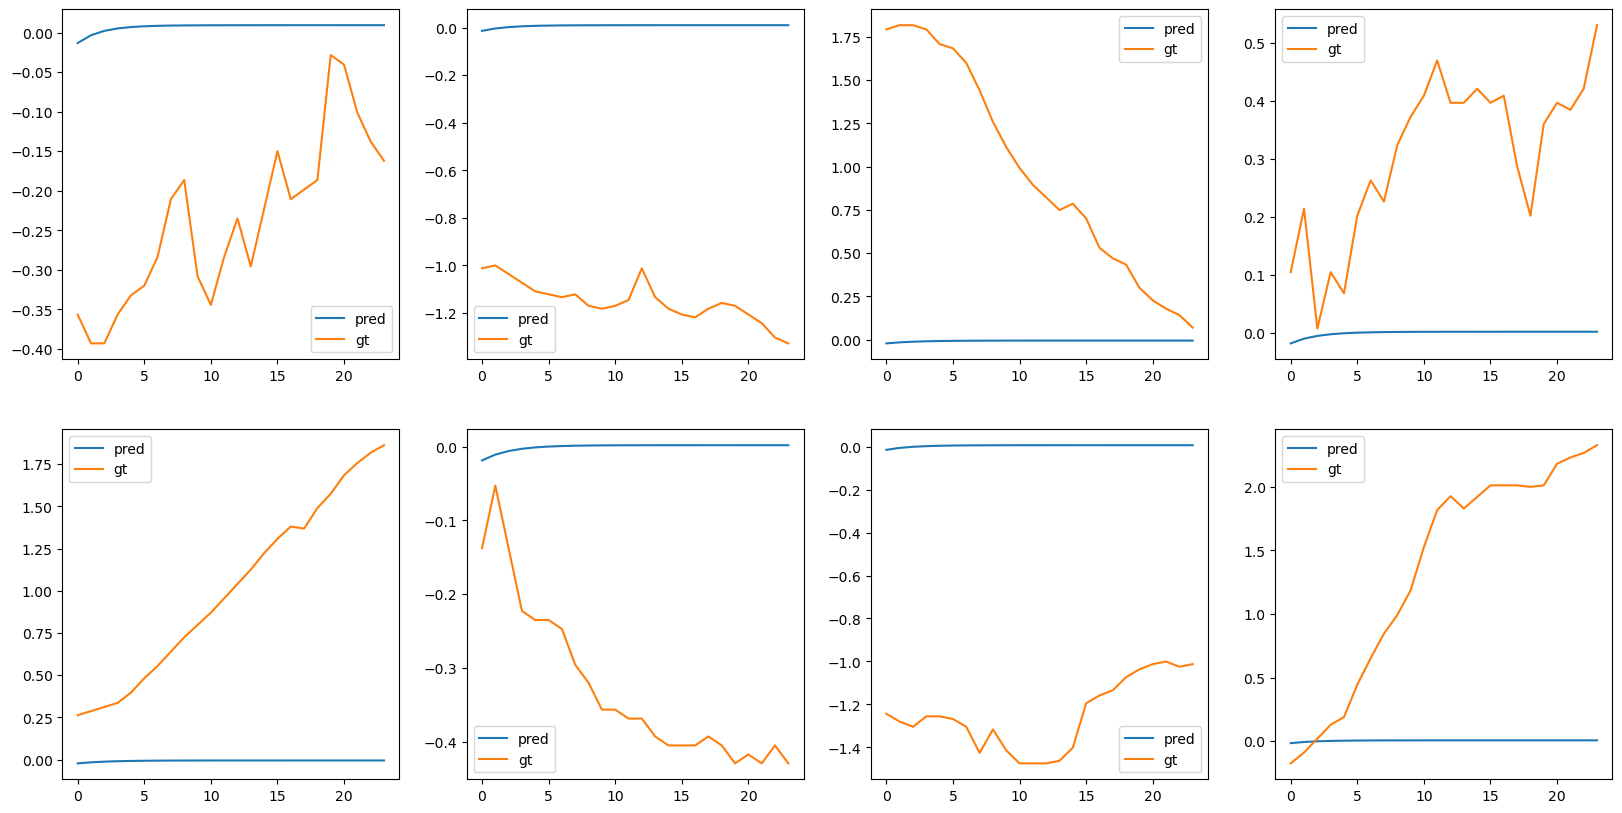

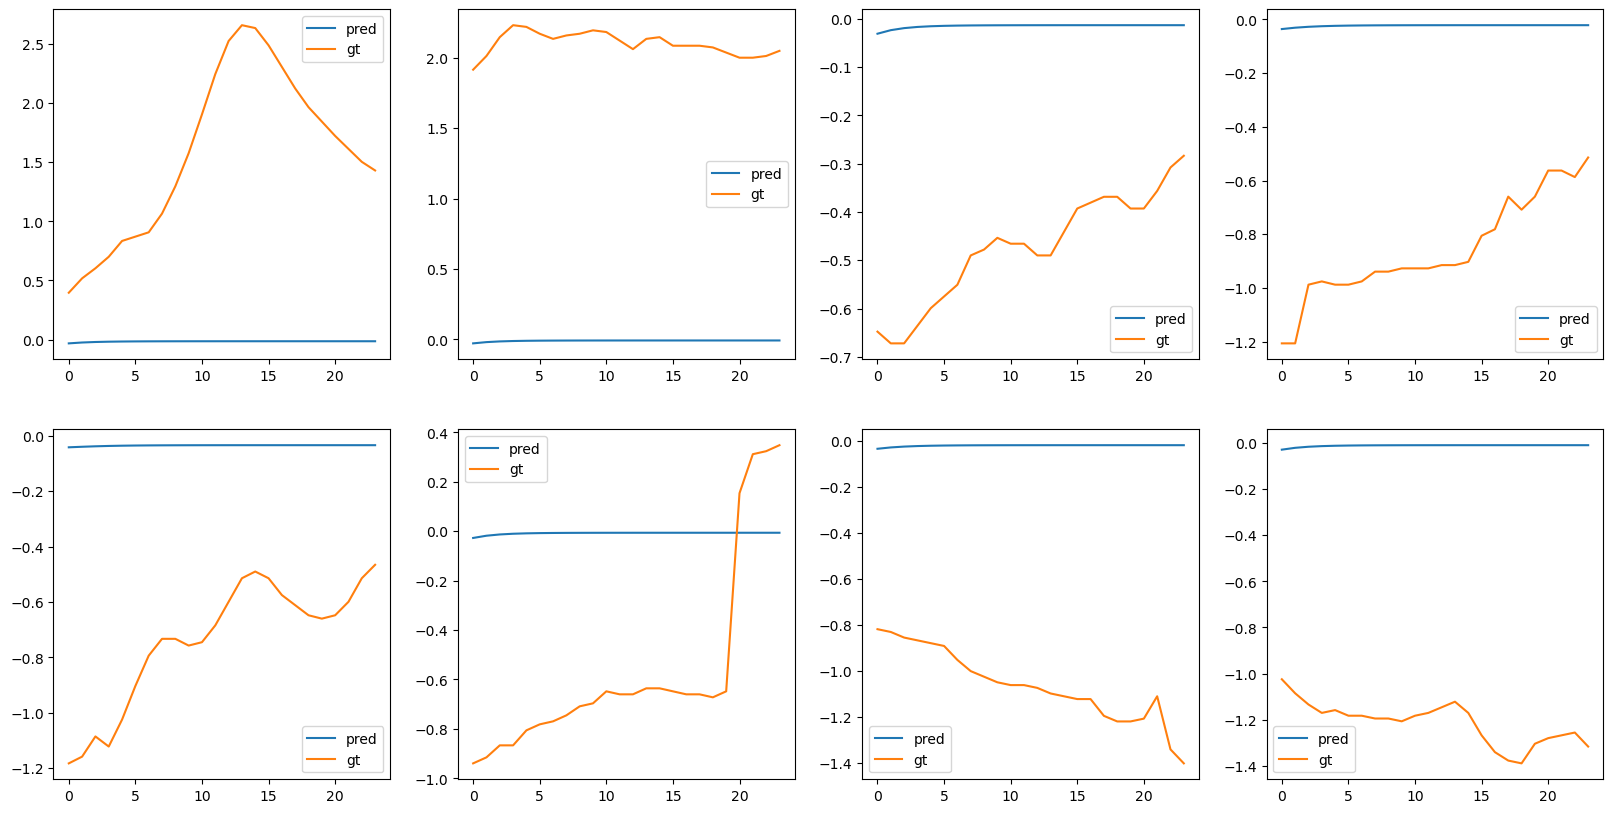

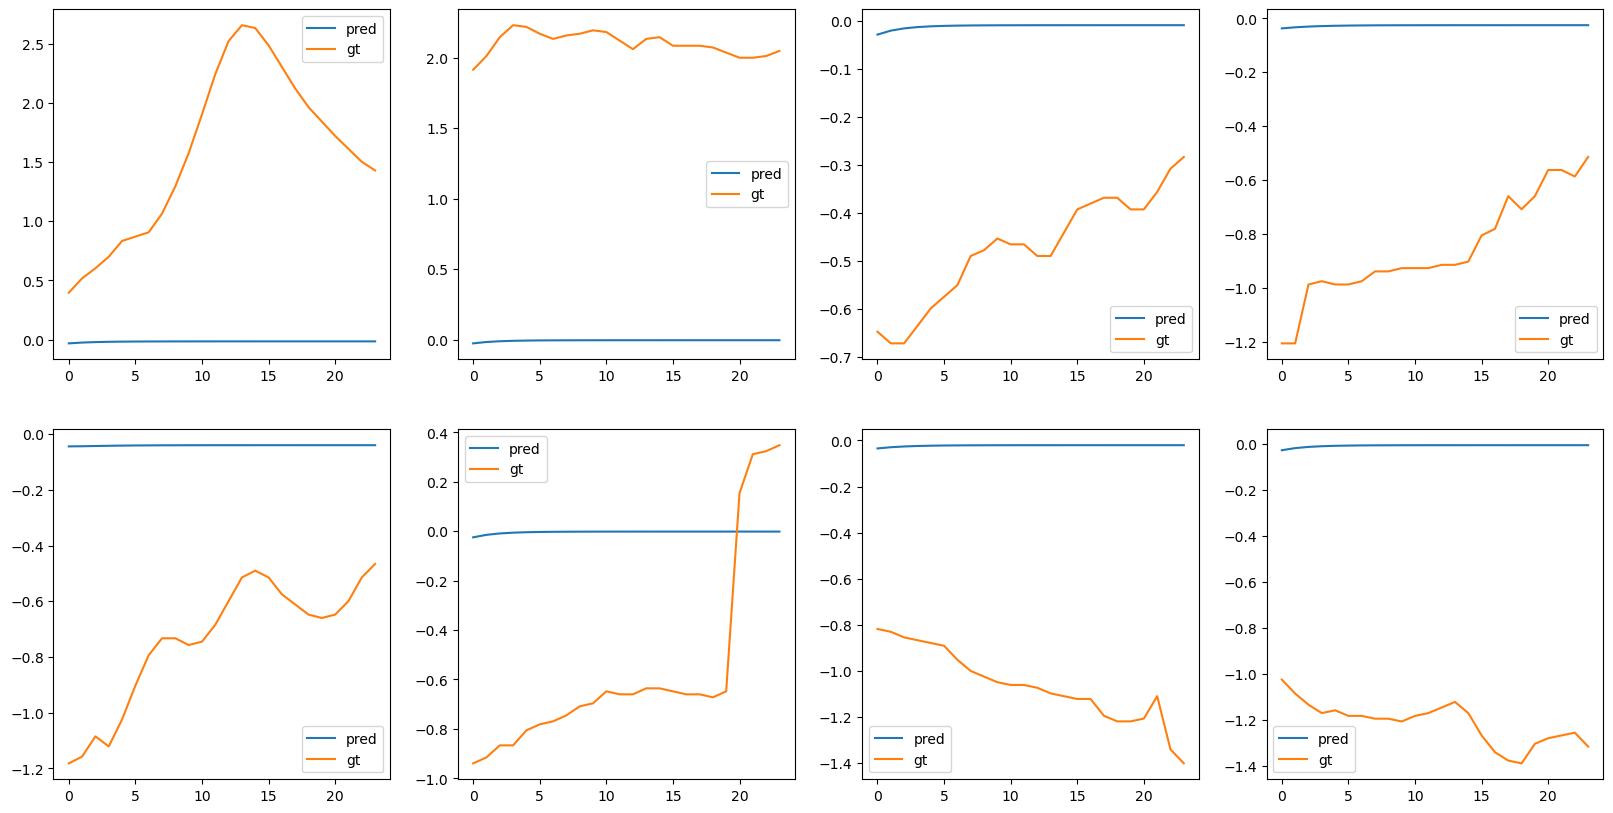

In [6]:
# train model
best_loss = 1e10000
model = LSTM_SeqtoSeq(192, 6, 24, 100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # add a scheduler for learning rate decay
for epoch in range(3):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs')) # outputs is a tuple (encoded, decoded) where we want the decoded values
        loss = criterion(outputs[1], d.get('outputs'))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
    scheduler.step() # update scheduler

    # plot as the model is training to see the outputs
    y_pred = outputs[1].squeeze().detach().numpy()
    y = d.get('outputs').squeeze().detach().numpy()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    for i in range(2):
        for j in range(4):
            ax[i, j].plot(y_pred[i*4+j, :], label='pred')
            ax[i, j].plot(y[i*4+j, :], label='gt')
            ax[i, j].legend()
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs[1], d.get('outputs'))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_lstm.pth')
        print(epoch+1)
# load best model
model.load_state_dict(torch.load('best_model_lstm.pth'))

In [8]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs[1], d.get('outputs'))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [3/100], Test Loss: 0.9990


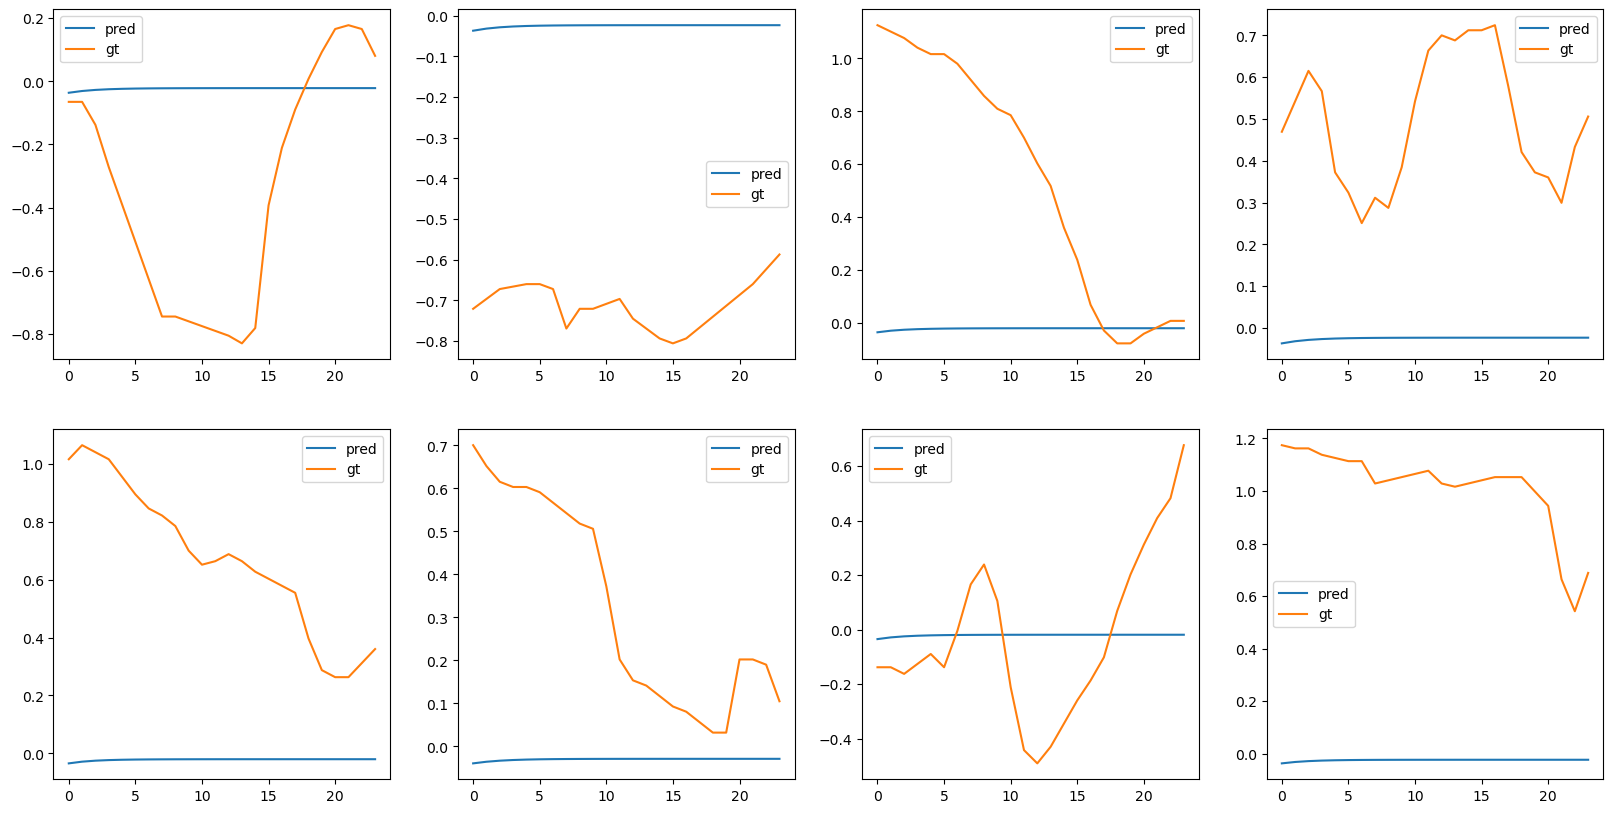

In [7]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[1][i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()